In [1]:
import os, sys, time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = 6, 4

sns.set(rc={"figure.figsize": (6, 4)})
sns.set(style="darkgrid")

print("Numpy version:", np.version.version)

# Set working dir to project root
while not os.getcwd().endswith("lmc"):
    os.chdir(os.pardir)

Numpy version: 1.23.5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

## Training / testing loops

In [4]:
from IPython.display import clear_output

from src.modules import Indexer, IndexedModel

def train_epoch(model, optimizer, scheduler = None):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in trainloader:
        data = x_batch.to(device)
        target = y_batch.to(device)

        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion_train(output, target)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        pred = torch.max(output, 1)[1].cpu().numpy()
        target = torch.max(target, 1)[1].cpu().numpy()
        acc = np.mean(pred == target)
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model, dataloader):
    loss_log, acc_log = [], []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            data = x_batch.to(device)
            target = y_batch.to(device)

            output = model(data)
            loss = criterion_test(output, target)

            pred = torch.max(output, 1)[1].cpu().numpy()
            acc = np.mean(pred == target.cpu().numpy())
            acc_log.append(acc)

            loss = loss.item()
            loss_log.append(loss)
    return np.mean(loss_log), np.mean(acc_log)

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title("{}".format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker="+", s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()
    
def train(n_epochs, model, opt, scheduler = None):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, scheduler)

        val_loss, val_acc = test(model, validloader)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(trainset) / batch_size
        val_log.append((steps * (epoch + 1), val_loss))
        val_acc_log.append((steps * (epoch + 1), val_acc))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title="accuracy")
        print("Epoch {} valid accuracy = {:.2%}".format(epoch, val_acc_log[-1][1]))
            
    evaluate(model)

def evaluate(model):
    print("Accuracy: {:.2%}".format(test(model, testloader)[1]))

def collect_statistics(model: IndexedModel, full: bool = False):
    if full:
        untracked_keys = []
        for key, module in model.modules.items():
            if not module.track_activations:
                untracked_keys.append(key)
                module.track_activations = True
    
    model.eval()
    with torch.no_grad(), model.track():
        #it = iter(range(70))
        for x_batch, _ in activation_loader:
            data = x_batch.to(device)
            output = model(data)
            #print(next(it))
    
    if full:
        for key in untracked_keys:
            model[key].track_activations = False

## Models

In [5]:
from src.models import ConvNetDepth, convnet_permutation_spec

## Permutation methods

### Permutation utils

In [6]:
from src.utils import interpolate
from src.permutation_specs import PermutationSpec, get_permuted_param, \
    apply_permutation, apply_permutation_stats

### Activation matching

In [7]:
from scipy.optimize import linear_sum_assignment

def covariance(module0: Indexer, module1: Indexer):
    outer = 0
    for a0, a1 in zip(module0.activations, module1.activations):
        outer = outer + (a1.T @ a0) / a0.shape[0]
    outer /= module0.num_runs
    cov = outer - torch.outer(module1.mean, module0.mean)
    return cov

def match_activations(model0: IndexedModel, model1: IndexedModel,
                      permutation_spec: PermutationSpec,
                      eps: float = 1e-4):
    device = model0[permutation_spec.perm2axes[0][0].key].device
    permutations = []
    for module0, module1 in zip(model0.modules.values(), model1.modules.values()):
        if not module0.track_activations:
            continue
        
        cov = covariance(module0, module1)
        corr = cov / (torch.outer(module1.std, module0.std) + eps)
        
        row_ind, col_ind = linear_sum_assignment(corr.numpy(), maximize=True)
        assert (row_ind == np.arange(corr.shape[0])).all()
        permutations.append(torch.tensor(col_ind, dtype=torch.long, device=device))
        
#         plt.imshow(corr)
#         plt.grid()
#         plt.show()
#         non_diag = corr[~np.diag(np.ones(corr.shape[0], dtype=bool))]
#         print(non_diag.max(), non_diag.mean())
#         assert (col_ind == np.arange(corr.shape[0])).all()
        
    apply_permutation(model0, permutation_spec, permutations)
    apply_permutation_stats(model0, permutation_spec, permutations)

### Weight matching

In [8]:
def match_weights(model0: IndexedModel, model1: IndexedModel,
                  permutation_spec: PermutationSpec,
                  max_iter: int = 100, eps: float = 1e-12,
                  seed: int = 42):
    set_random_seed(seed)

    device = model0[permutation_spec.perm2axes[0][0].key].device
    perm_sizes = [model0[axes[0].key].shape[axes[0].axis]
                  for axes in permutation_spec.perm2axes]
    permutations = [torch.arange(size, dtype=torch.long, device=device)
                    for size in perm_sizes]
    for iteration in range(max_iter):
        progress = False
        for p in np.random.choice(len(permutations), len(permutations), replace=False):
            size = perm_sizes[p]
            A = torch.zeros((size, size), device=device)
            for key, axis in permutation_spec.perm2axes[p]:
                if not model0[key.split(".")[0]].match_weights:
                    continue

                w1 = model1[key].detach()
                w0 = get_permuted_param(model0, permutation_spec, permutations,
                                        key, except_axis=axis)
                w1 = torch.movedim(w1, axis, 0).reshape(size, -1)
                w0 = torch.movedim(w0, axis, 0).reshape(size, -1)
                A += w1 @ w0.T

            row_ind, col_ind = linear_sum_assignment(A.cpu().numpy(), maximize=True)
            assert (row_ind == np.arange(A.shape[0])).all()
            new_permutation = torch.tensor(col_ind, dtype=torch.long, device=device)

            oldL = torch.diag(A[permutations[p]]).sum()
            newL = torch.diag(A[new_permutation]).sum()
            progress = progress or newL > oldL + eps

            permutations[p] = new_permutation

        if not progress:
            break
    
    apply_permutation(model0, permutation_spec, permutations)

### Sinkhorn WM (L2)

In [9]:
from copy import deepcopy

from src.models import SinkhornRebasinModel
from src.loss import DistLoss

def match_weights_sinkhorn(model0: IndexedModel, model1: IndexedModel,
                           permutation_spec: PermutationSpec,
                           max_iter: int = 50, sinkhorn_iter: int = 20,
                           sinkhorn_tau: float = 1.0, seed: int = 42):
    set_random_seed(seed)

    model0.requires_grad(False)
    model1.requires_grad(False)
    device = model0[permutation_spec.perm2axes[0][0].key].device
    permuted_model0 = deepcopy(model0)
    perm_sizes = [model0[axes[0].key].shape[axes[0].axis]
                  for axes in permutation_spec.perm2axes]
    
#     random_perms = [torch.tensor(np.random.choice(size, size, replace=False),
#                                  dtype=torch.long, device=device)
#                     for size in perm_sizes]
#     model1 = apply_permutation(model0, permutation_spec, random_perms, preserve_grad=True)
#     model1.requires_grad(False)
    
    rebasin_model = SinkhornRebasinModel(permutation_spec, perm_sizes,
                                         sinkhorn_iter, sinkhorn_tau)
    rebasin_model.to(device)
    criterion = DistLoss(permutation_spec)
    optimizer = torch.optim.AdamW(rebasin_model.parameters(), lr=0.1)
    
    for iteration in range(max_iter):
        # Training
        rebasin_model.train()  # This uses soft permutation matrices

        optimizer.zero_grad()
        
        rebasin_model(model0, out=permuted_model0)
        train_loss = criterion(permuted_model0, model1)
        train_loss.backward()
        optimizer.step()  # Only updates the permutation matrices

        # Validation
        rebasin_model.eval()  # This uses hard permutation matrices
        
        with torch.no_grad():
            rebasin_model(model0, out=permuted_model0)
            valid_loss = criterion(permuted_model0, model1)
            
        print(
            "Iteration {:02d}: training loss {:1.3f}, validation loss {:1.3f}".format(
                iteration, train_loss, valid_loss
            )
        )
        if valid_loss == 0:
            break
    
    permutations = rebasin_model.estimate_permutations()
    apply_permutation(model0, permutation_spec, permutations)

### Sinkhorn direct (Mid, Rnd)

In [22]:
def sinkhorn_direct(model0: IndexedModel, model1: IndexedModel,
                    permutation_spec: PermutationSpec,
                    mode: str = "random", repair: str = "none",
                    max_iter: int = 20, sinkhorn_iter: int = 20,
                    sinkhorn_tau: float = 1.0, seed: int = 42):
    set_random_seed(seed)

    model0.requires_grad(False)
    model1.requires_grad(False)
    model0.eval()
    model1.eval()
    device = model0[permutation_spec.perm2axes[0][0].key].device
    perm_sizes = [model0[axes[0].key].shape[axes[0].axis]
                  for axes in permutation_spec.perm2axes]
    
    rebasin_model = SinkhornRebasinModel(permutation_spec, perm_sizes,
                                         sinkhorn_iter, sinkhorn_tau,
                                         init="random")
    rebasin_model.to(device)
    optimizer = torch.optim.AdamW(rebasin_model.parameters(), lr=0.1)
    
    for iteration in range(max_iter):
        # Training
        rebasin_model.train()  # This uses soft permutation matrices
        train_loss = 0
        for x_batch, y_batch in trainloader:
            data = x_batch.to(device)
            target = y_batch.to(device)

            optimizer.zero_grad()
            permuted_model0 = deepcopy(model0)
            rebasin_model(model0, out=permuted_model0)
            if mode == "random":
                alpha = np.random.rand()
            else:
                alpha = 0.5
            interpolated = interpolate(permuted_model0, model1, alpha, copy=False)
            
            if repair == "closed":
                repair_closed(permuted_model0, model1, interpolated, alpha)
            elif repair == "trainmode":
                repair_trainmode(interpolated)
            elif repair == "sphere":
                repair_sphere(permuted_model0, model1, interpolated, alpha)
            
            output = interpolated(data)

            loss = criterion_train(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        train_loss /= len(trainloader)

        # Validation
        rebasin_model.eval()  # This uses hard permutation matrices
        with torch.no_grad():
            permuted_model0 = deepcopy(model0)
            rebasin_model(model0, out=permuted_model0)
            interpolated = interpolate(permuted_model0, model1, alpha, copy=False)
            
            if repair == "closed":
                repair_closed(permuted_model0, model1, interpolated, alpha)
            elif repair == "trainmode":
                repair_trainmode(interpolated)
            elif repair == "sphere":
                repair_sphere(permuted_model0, model1, interpolated, alpha)
        valid_loss = test(interpolated, validloader)[0]
        
        print(
            "Iteration {:02d}: training loss {:1.3f}, validation loss {:1.3f}".format(
                iteration, train_loss, valid_loss
            )
        )
        if valid_loss == 0:
            break
    
    permutations = rebasin_model.estimate_permutations()
    apply_permutation(model0, permutation_spec, permutations)

### REPAIR

In [11]:
def repair_closed(model0: IndexedModel, model1: IndexedModel,
                  interpolated: IndexedModel, alpha: float = 0.5):
    for module0, module1, module_i in zip(model0.modules.values(),
                                             model1.modules.values(),
                                             interpolated.modules.values()):
        cov = covariance(module0, module1)
        rescale = ((1 - alpha) * module0.std + alpha * module1.std) / \
                  ((1 - alpha) ** 2 * module0.var + alpha ** 2 * module1.var +
                   2 * alpha * (1 - alpha) * torch.diag(cov)) ** (1 / 2)
        rescale = rescale.to(module_i.operator.weight.device)
        
        weight = module_i.operator.weight.detach()
        bias = module_i.operator.bias.detach()
        module_i.operator.weight.data = weight * rescale.view(-1, *([1] * (weight.dim() - 1)))
        module_i.operator.bias.data = bias * rescale

def repair_trainmode(interpolated: IndexedModel):
    for module in interpolated.modules.values():
        if "norm" in module.operator.__class__.__name__.lower():
            module.operator.running_mean = None
            module.operator.running_var = None

def repair_sphere(model0: IndexedModel, model1: IndexedModel,
                  interpolated: IndexedModel, alpha: float = 0.5):
    repair_trainmode(interpolated)
    for module0, module1, module_i in zip(model0.modules.values(),
                                             model1.modules.values(),
                                             interpolated.modules.values()):
        norm0 = torch.norm(module0.operator.weight.detach())
        norm1 = torch.norm(module1.operator.weight.detach())
        norm = (1 - alpha) * norm0 + alpha * norm1
        rescale = norm / torch.norm(module_i.operator.weight.detach())
        
        weight = module_i.operator.weight.detach()
        bias = module_i.operator.bias.detach()
        module_i.operator.weight.data = weight * rescale
        module_i.operator.bias.data = bias * rescale

## Train two models

In [12]:
checkpoint_dir = "resources/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

data_dir = "/home/sergej/data"
os.makedirs(data_dir, exist_ok=True)

### CIFAR10

In [13]:
import torch.nn.functional as F

class MixupCrossEntropyLoss(nn.Module):
    def forward(self, input, target):
        logged_input = F.log_softmax(input, dim=-1)
        loss = -(target * logged_input).sum() / input.shape[0]
        return loss

In [14]:
from src.augmentations import MixupWrapper, CutoutWrapper, CombineWrapper, SmoothOHEWrapper

p = 0.5
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply(
        [transforms.RandomRotation((-15, 15), interpolation=transforms.InterpolationMode.BILINEAR)],
        p=p),
    transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128
subset_size = 50 * batch_size

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=train_transform)
trainset, validset = torch.utils.data.random_split(trainset, [45000, 5000],
                                                   generator=torch.Generator().manual_seed(42))
trainset = SmoothOHEWrapper(
    CombineWrapper(
        MixupWrapper(trainset, alpha=0.8, p=0.5),
        CutoutWrapper(trainset, size=10, p=0.5)
    ),
    n_classes=10
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
activation_subset = torch.utils.data.Subset(trainset, list(range(subset_size)))
activation_loader = torch.utils.data.DataLoader(activation_subset, batch_size=batch_size,
                                                shuffle=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False)

testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

criterion_train = MixupCrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss()

device = "cuda:0"

Files already downloaded and verified
Files already downloaded and verified


In [15]:
from dataclasses import dataclass

@dataclass
class CIFARConvNetConfig:
    init_channels = 64
    num_classes = 10
    max_depth = 3
    matching_mode = "post_activation"

config = CIFARConvNetConfig()

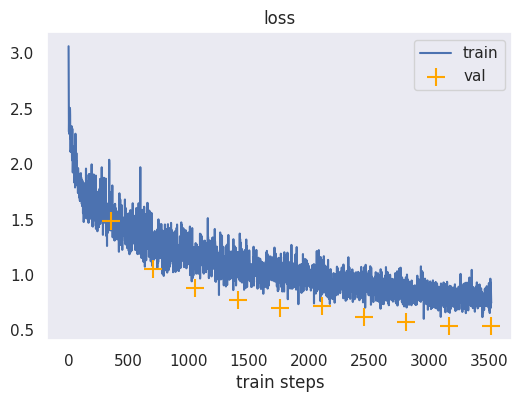

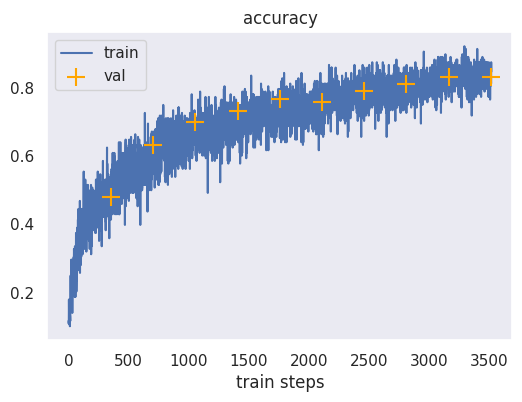

Epoch 9 valid accuracy = 83.30%
Accuracy: 83.66%


In [16]:
set_random_seed(42)

lr = 1e-2
num_epochs = 10

model0 = ConvNetDepth(config)
model0.to(device)
optim = torch.optim.SGD(model0.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model0, optim, scheduler)
torch.save(model0.state_dict(), checkpoint_dir + "/cifar_conv_aug0.pth")

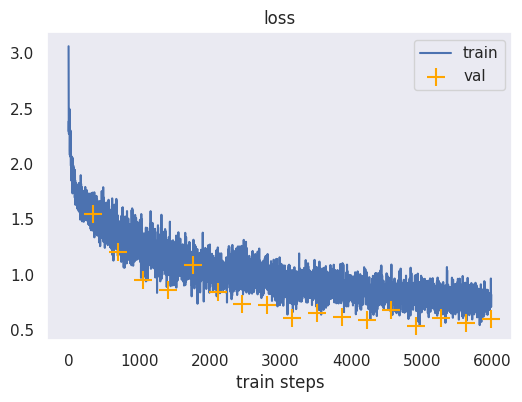

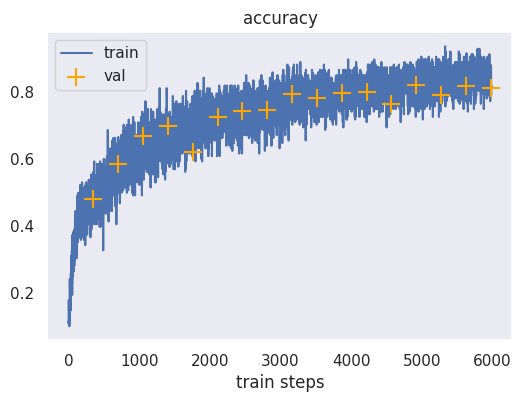

Epoch 16 valid accuracy = 81.23%
Epoch 17 of 40


KeyboardInterrupt: 

In [16]:
set_random_seed(42)

lr = 1e-2
num_epochs = 40

model0 = ConvNetDepth(config)
model0.to(device)
optim = torch.optim.SGD(model0.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model0, optim, scheduler)
torch.save(model0.state_dict(), checkpoint_dir + "/cifar_conv_aug0.pth")

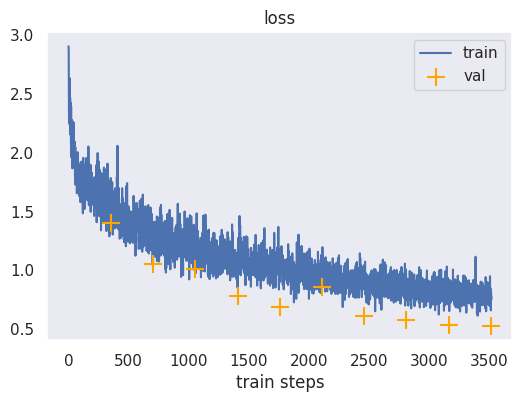

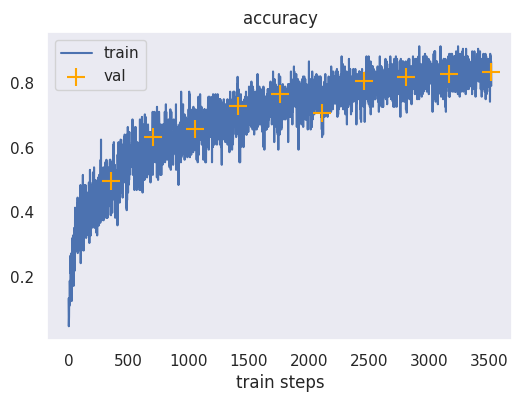

Epoch 9 valid accuracy = 83.44%
Accuracy: 84.77%


In [17]:
set_random_seed(92)

lr = 1e-2
num_epochs = 10

model1 = ConvNetDepth(config)
model1.to(device)
optim = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model1, optim, scheduler)
torch.save(model1.state_dict(), checkpoint_dir + "/cifar_conv_aug1.pth")

## Permute the weights of model 0 to align with model 1

In [16]:
from tqdm.auto import tqdm

def get_interpolation(model0, model1, alphas = np.linspace(0, 1, 25),
                           repair = "none", loader = None):
    if loader is None:
        loader = testloader
    
    accuracies = []
    losses = []
    for alpha in tqdm(alphas, desc="Interpolate"):
        interpolated = interpolate(model0, model1, alpha)
        if repair == "closed":
            repair_closed(model0, model1, interpolated, alpha)
        elif repair == "trainmode":
            repair_trainmode(interpolated)
        elif repair == "sphere":
            repair_sphere(model0, model1, interpolated, alpha)
        loss, accuracy = test(interpolated, loader)
        accuracies += [accuracy]
        losses += [loss]
        
        del interpolated

    return accuracies, losses, alphas

def get_variance(model):
    return np.array([
        module.var.mean().item() for module in model.modules.values()
    ], dtype=float)

def reload_models():
    global model0, model1
    
    if model_type == "mlp":
        model0 = MLPModel(config)
        model0.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_model0.pth"))
        model0.to(device)
        model1 = MLPModel(config)
        model1.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_model1.pth"))
        model1.to(device)
    elif model_type == "conv":
        model0 = ConvNetDepth(config)
        model0.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_conv0.pth"))
        model0.to(device)
        model1 = ConvNetDepth(config)
        model1.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_conv1.pth"))
        model1.to(device)

def activation_matching():
    reload_models()
    for model in [model0, model1]:
        collect_statistics(model, full=True)
    match_activations(model0, model1, perm_spec)

def weight_matching():
    reload_models()
    match_weights(model0, model1, perm_spec)

def sinkhorn_weight_matching():
    reload_models()
    match_weights_sinkhorn(model0, model1, perm_spec)

def sinkhorn_direct_matching(repair = "none"):
    reload_models()
    sinkhorn_direct(model0, model1, perm_spec, repair)

### CIFAR10

### ConvNet

In [17]:
config = CIFARConvNetConfig()
perm_spec = convnet_permutation_spec(config)
dataset_name = "cifar"
model_type = "conv"

In [18]:
reload_models()
accs, losses, alphas = get_interpolation(model0, model1)
accs_tr, losses_tr, _ = get_interpolation(model0, model1, repair="trainmode")
# accs_sph, losses_sph, _ = get_interpolation(model0, model1, repair="sphere")
# for model in [model0, model1]:
#     collect_statistics(model, full=True)
# accs_rep, losses_rep, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1
# del model

activation_matching()
# post_act_accs, post_act_losses, _ = get_interpolation(model0, model1)
post_act_tr_accs, post_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# post_act_sph_accs, post_act_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# post_act_rep_accs, post_act_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

weight_matching()
# weight_accs, weight_losses, _ = get_interpolation(model0, model1)
weight_tr_accs, weight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# weight_sph_accs, weight_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# for model in [model0, model1]:
#     collect_statistics(model, full=True)
# weight_rep_accs, weight_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1
# del model

# config.matching_mode = "pre_activation"
# activation_matching()
# pre_act_accs, pre_act_losses, _ = get_interpolation(model0, model1)
# pre_act_tr_accs, pre_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# pre_act_sph_accs, pre_act_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# pre_act_rep_accs, pre_act_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

# del model0
# del model1

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Without batchnorm stats matching

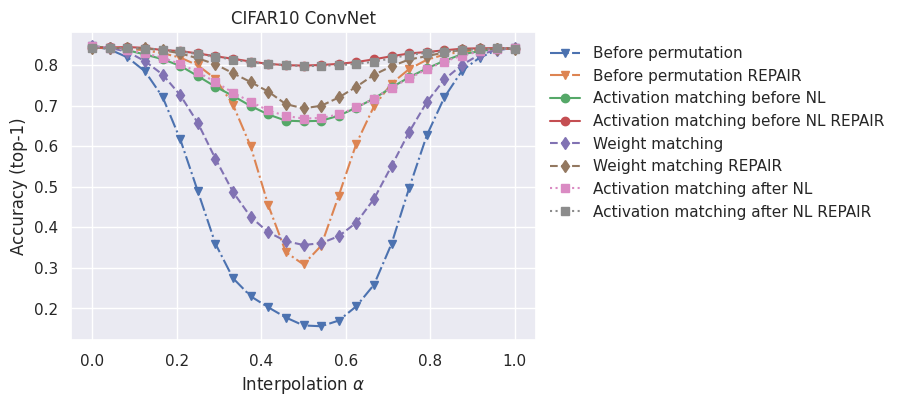

In [23]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
# plt.plot(alphas, accs_rep, label="Before permutation REPAIR closed", marker="v", linestyle="-.")
plt.plot(alphas, accs_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
# plt.plot(alphas, accs_sph, label="Before permutation REPAIR sphere", marker="v", linestyle="-.")
plt.plot(alphas, pre_act_accs, label="Activation matching before NL", marker="o")
# plt.plot(alphas, pre_act_rep_accs, label="Activation matching before NL REPAIR closed", marker="o")
plt.plot(alphas, pre_act_tr_accs, label="Activation matching before NL REPAIR", marker="o")
# plt.plot(alphas, pre_act_sph_accs, label="Activation matching before NL REPAIR sphere", marker="o")
plt.plot(alphas, weight_accs, label="Weight matching", marker="d", linestyle="--")
# plt.plot(alphas, weight_rep_accs, label="Weight matching REPAIR closed", marker="d", linestyle="--")
plt.plot(alphas, weight_tr_accs, label="Weight matching REPAIR", marker="d", linestyle="--")
# plt.plot(alphas, weight_sph_accs, label="Weight matching REPAIR sphere", marker="d", linestyle="--")
plt.plot(alphas, post_act_accs, label="Activation matching after NL", marker="s", linestyle=":")
# plt.plot(alphas, post_act_rep_accs, label="Activation matching after NL REPAIR closed", marker="s", linestyle=":")
plt.plot(alphas, post_act_tr_accs, label="Activation matching after NL REPAIR", marker="s", linestyle=":")
# plt.plot(alphas, post_act_sph_accs, label="Activation matching after NL REPAIR sphere", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

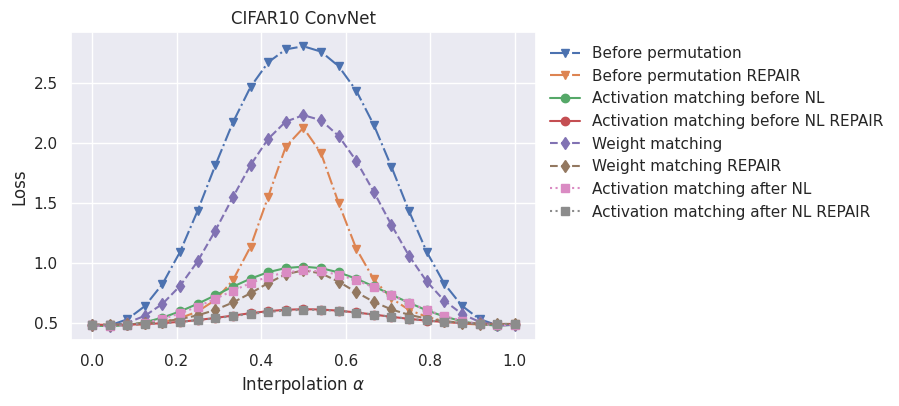

In [24]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
# plt.plot(alphas, losses_rep, label="Before permutation REPAIR closed", marker="v", linestyle="-.")
plt.plot(alphas, losses_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
# plt.plot(alphas, losses_sph, label="Before permutation REPAIR sphere", marker="v", linestyle="-.")
plt.plot(alphas, pre_act_losses, label="Activation matching before NL", marker="o")
# plt.plot(alphas, pre_act_rep_losses, label="Activation matching before NL REPAIR closed", marker="o")
plt.plot(alphas, pre_act_tr_losses, label="Activation matching before NL REPAIR", marker="o")
# plt.plot(alphas, pre_act_sph_losses, label="Activation matching before NL REPAIR sphere", marker="o")
plt.plot(alphas, weight_losses, label="Weight matching", marker="d", linestyle="--")
# plt.plot(alphas, weight_rep_losses, label="Weight matching REPAIR closed", marker="d", linestyle="--")
plt.plot(alphas, weight_tr_losses, label="Weight matching REPAIR", marker="d", linestyle="--")
# plt.plot(alphas, weight_sph_losses, label="Weight matching REPAIR sphere", marker="d", linestyle="--")
plt.plot(alphas, post_act_losses, label="Activation matching after NL", marker="s", linestyle=":")
# plt.plot(alphas, post_act_rep_losses, label="Activation matching after NL REPAIR closed", marker="s", linestyle=":")
plt.plot(alphas, post_act_tr_losses, label="Activation matching after NL REPAIR", marker="s", linestyle=":")
# plt.plot(alphas, post_act_sph_losses, label="Activation matching after NL REPAIR sphere", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

In [35]:
reload_models()

accs, losses, alphas = get_interpolation(model0, model1)

del model0
del model1

sinkhorn_weight_matching()
sweight_accs, sweight_losses, _ = get_interpolation(model0, model1)
sweight_tr_accs, sweight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

Iteration 00: training loss 0.030, validation loss 0.040
Iteration 01: training loss 0.029, validation loss 0.040
Iteration 02: training loss 0.028, validation loss 0.040
Iteration 03: training loss 0.027, validation loss 0.040
Iteration 04: training loss 0.026, validation loss 0.039
Iteration 05: training loss 0.026, validation loss 0.034
Iteration 06: training loss 0.025, validation loss 0.033
Iteration 07: training loss 0.024, validation loss 0.031
Iteration 08: training loss 0.024, validation loss 0.030
Iteration 09: training loss 0.023, validation loss 0.030
Iteration 10: training loss 0.023, validation loss 0.030
Iteration 11: training loss 0.023, validation loss 0.029
Iteration 12: training loss 0.022, validation loss 0.029
Iteration 13: training loss 0.022, validation loss 0.028
Iteration 14: training loss 0.021, validation loss 0.028
Iteration 15: training loss 0.021, validation loss 0.028
Iteration 16: training loss 0.021, validation loss 0.028
Iteration 17: training loss 0.0

Iteration 149: training loss 0.014, validation loss 0.023


Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

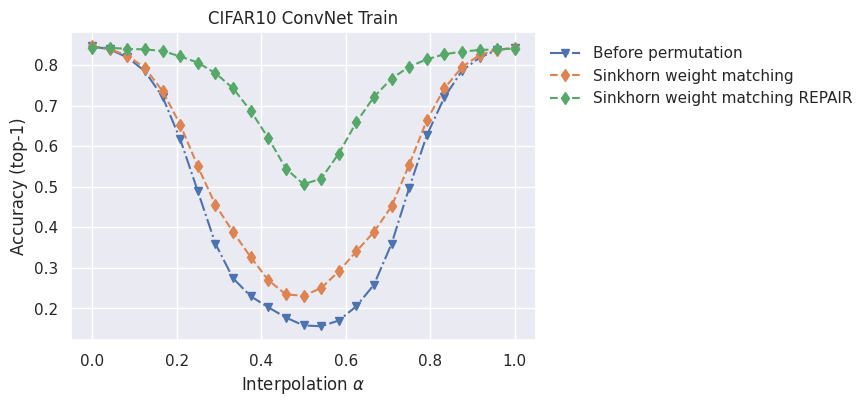

In [36]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, sweight_accs, label="Sinkhorn weight matching", marker="d", linestyle="--")
plt.plot(alphas, sweight_tr_accs, label="Sinkhorn weight matching REPAIR", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

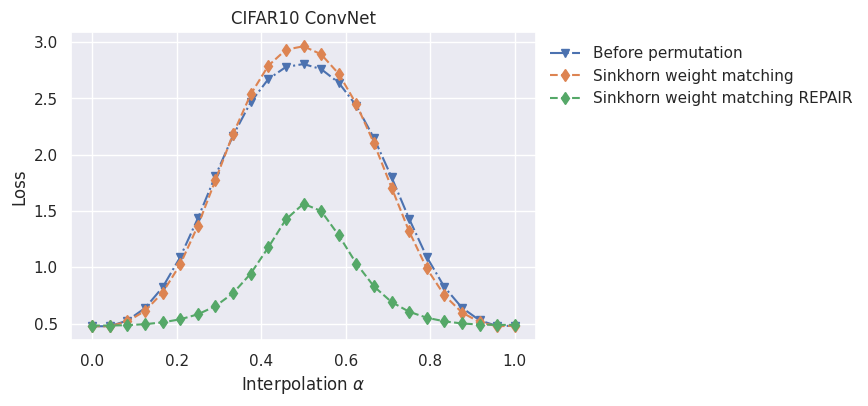

In [37]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, sweight_losses, label="Sinkhorn weight matching", marker="d", linestyle="--")
plt.plot(alphas, sweight_tr_losses, label="Sinkhorn weight matching REPAIR", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

In [21]:
reload_models()

accs, losses, alphas = get_interpolation(model0, model1)

del model0
del model1

sinkhorn_weight_matching()
sweight_accs, sweight_losses, _ = get_interpolation(model0, model1)
sweight_tr_accs, sweight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

Iteration 00: training loss 0.039, validation loss 0.052
Iteration 01: training loss 0.038, validation loss 0.052
Iteration 02: training loss 0.037, validation loss 0.052
Iteration 03: training loss 0.036, validation loss 0.052
Iteration 04: training loss 0.035, validation loss 0.052
Iteration 05: training loss 0.034, validation loss 0.044
Iteration 06: training loss 0.033, validation loss 0.042
Iteration 07: training loss 0.032, validation loss 0.040
Iteration 08: training loss 0.032, validation loss 0.040
Iteration 09: training loss 0.031, validation loss 0.039
Iteration 10: training loss 0.031, validation loss 0.038
Iteration 11: training loss 0.030, validation loss 0.038
Iteration 12: training loss 0.030, validation loss 0.037
Iteration 13: training loss 0.029, validation loss 0.037
Iteration 14: training loss 0.029, validation loss 0.036
Iteration 15: training loss 0.029, validation loss 0.036
Iteration 16: training loss 0.028, validation loss 0.035
Iteration 17: training loss 0.0

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

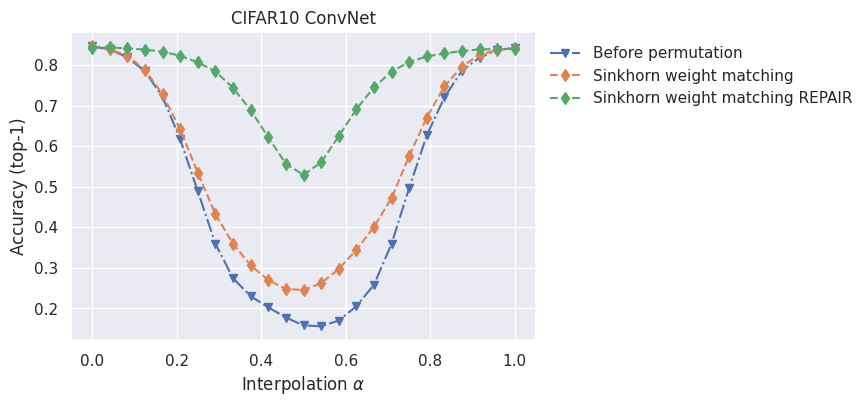

In [22]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, sweight_accs, label="Sinkhorn weight matching", marker="d", linestyle="--")
plt.plot(alphas, sweight_tr_accs, label="Sinkhorn weight matching REPAIR", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

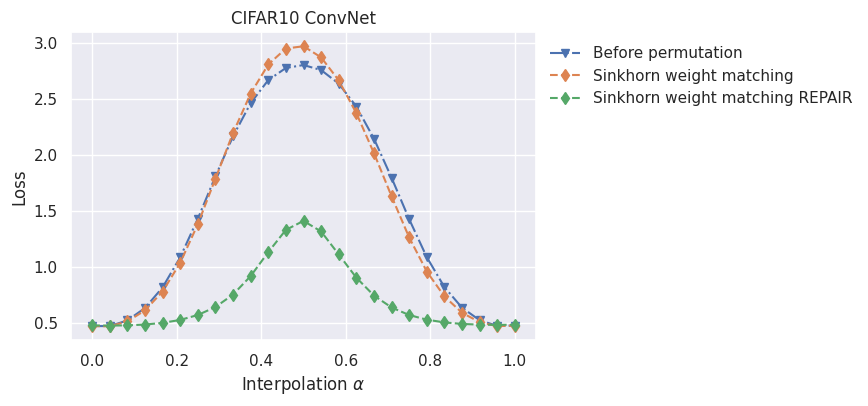

In [23]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, sweight_losses, label="Sinkhorn weight matching", marker="d", linestyle="--")
plt.plot(alphas, sweight_tr_losses, label="Sinkhorn weight matching REPAIR", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

Direct

In [23]:
# reload_models()

# accs, losses, alphas = get_interpolation(model0, model1)
# accs_tr, losses_tr, _ = get_interpolation(model0, model1, repair="trainmode")

# del model0
# del model1

sinkhorn_direct_matching(repair="trainmode")
# sweight_accs, sweight_losses, _ = get_interpolation(model0, model1)
sweight_tr_accs, sweight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

Iteration 00: training loss 1.584, validation loss 1.361
Iteration 01: training loss 1.285, validation loss 1.411
Iteration 02: training loss 1.247, validation loss 1.151
Iteration 03: training loss 1.228, validation loss 1.112
Iteration 04: training loss 1.225, validation loss 1.084
Iteration 05: training loss 1.212, validation loss 1.174
Iteration 06: training loss 1.210, validation loss 1.190
Iteration 07: training loss 1.212, validation loss 1.121
Iteration 08: training loss 1.202, validation loss 1.156
Iteration 09: training loss 1.196, validation loss 1.281
Iteration 10: training loss 1.198, validation loss 1.196
Iteration 11: training loss 1.198, validation loss 1.231
Iteration 12: training loss 1.192, validation loss 1.142
Iteration 13: training loss 1.191, validation loss 1.112
Iteration 14: training loss 1.194, validation loss 1.172
Iteration 15: training loss 1.185, validation loss 1.154
Iteration 16: training loss 1.192, validation loss 1.133
Iteration 17: training loss 1.1

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

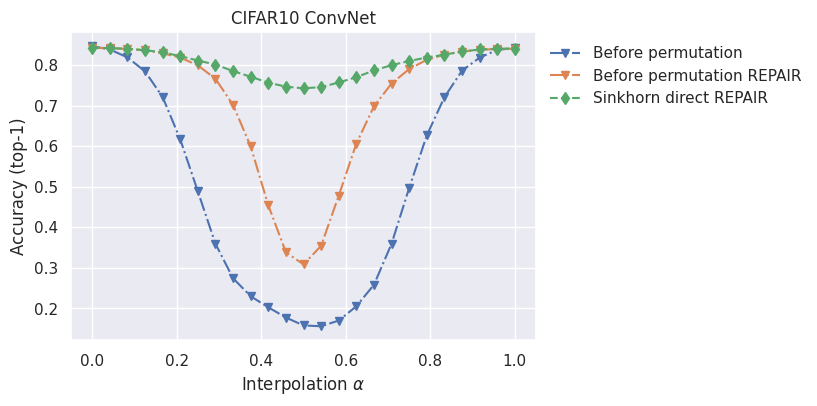

In [25]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, accs_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
# plt.plot(alphas, sweight_accs, label="Sinkhorn direct", marker="d", linestyle="--")
plt.plot(alphas, sweight_tr_accs, label="Sinkhorn direct REPAIR", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

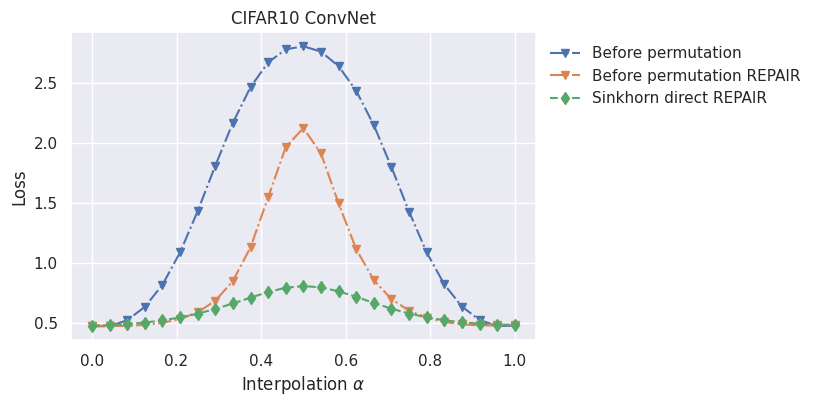

In [26]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, losses_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
# plt.plot(alphas, sweight_losses, label="Sinkhorn direct", marker="d", linestyle="--")
plt.plot(alphas, sweight_tr_losses, label="Sinkhorn direct REPAIR", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

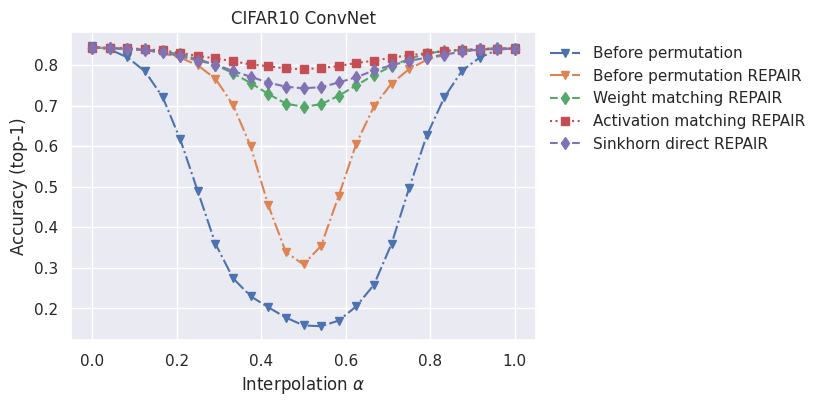

In [24]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, accs_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
plt.plot(alphas, weight_tr_accs, label="Weight matching REPAIR", marker="d", linestyle="--")
plt.plot(alphas, post_act_tr_accs, label="Activation matching REPAIR", marker="s", linestyle=":")
# plt.plot(alphas, sweight_accs, label="Sinkhorn direct", marker="d", linestyle="--")
plt.plot(alphas, sweight_tr_accs, label="Sinkhorn direct REPAIR", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

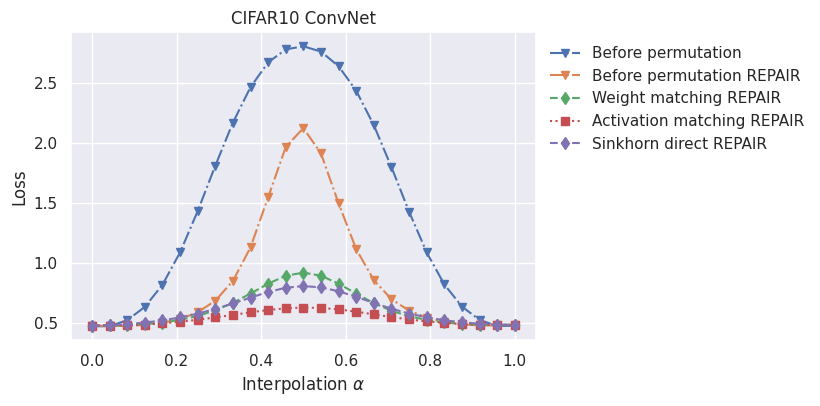

In [27]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, losses_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
plt.plot(alphas, weight_tr_losses, label="Weight matching REPAIR", marker="d", linestyle="--")
plt.plot(alphas, post_act_tr_losses, label="Activation matching REPAIR", marker="s", linestyle=":")
# plt.plot(alphas, sweight_losses, label="Sinkhorn direct", marker="d", linestyle="--")
plt.plot(alphas, sweight_tr_losses, label="Sinkhorn direct REPAIR", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()